### CV libraries in Pytorch
* torchvision
* torchvision.datasets  (this notebook will use FashionMINIST())
* torchvision.models
* torchvision.transforms
* torch.utils.data.Dataset  (base dataset class)
* torch.utils.data.DataLoader (create a python iterable over a dataset)

Note: The torch.utils.data.Dataset and torch.utils.data.DataLoader classes aren't only for computer vision in PyTorch, they are capable of dealing with many different types of data.

DataLoader:将图像数据变成python批迭代器用于在每epoch处理批次的生成。

In [1]:
# outlines
# import torch
import torch
from torch import nn

# import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# import matplotlib for visualize
import matplotlib.pyplot as plt

# check torch version
print(torch.__version__)
print(torchvision.__version__)

2.1.2
0.16.2


### Prepare data sets

In [2]:
# setup training data
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

# setup test data
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [4]:
# find classes by .classes
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

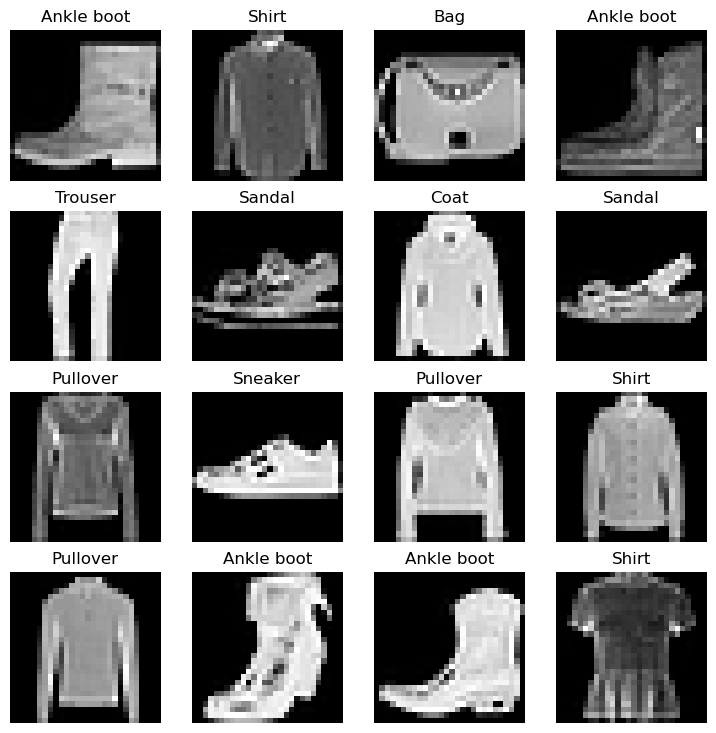

In [7]:
# plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

In [8]:
# create dataloader for train and test sets (parameters: batch_size, shuffle)
# shuffle the train data, don't shuffle the test data
from torch.utils.data import DataLoader

# setup batch size
BATCH_SIZE = 32

# True datasets into iterables batches
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                             shuffle=True)
test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)
print(f"train_dataloader: {train_dataloader}")
print(f"test_dataloader: {test_dataloader}")
print(f"the length: {len(train_dataloader)}, {len(test_dataloader)}")

train_dataloader: <torch.utils.data.dataloader.DataLoader object at 0x16997a650>
test_dataloader: <torch.utils.data.dataloader.DataLoader object at 0x169bc8ad0>
the length: 1875, 313


In [10]:
# check what's inside the dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))

In [18]:
# create a function to time experiment
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device=None):
    """
    Print difference between start and end time.
    Args:
        start(float): start time of computation.
        end(float): end time of computation.
        device([type], optional): Device that compute is running on.
                                  Default is None.
    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

### Building a Convolutional Neural Network (CNN)

In [47]:
# create a convolutional neural network
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture copying TinyVGG
    """
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [63]:
# setup loss and optimizer 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

In [65]:
# training and test loop
torch.manual_seed(42)
from timeit import default_timer as timer
train_time_start_model_2 = timer()

epochs = 3
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n-----")
    train_step(
        data_loader=train_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(
        data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )
train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(
    start=train_time_start_model_2,
    end=train_time_end_model_2,
    device=device
)

Epoch: 0
-----
Train Loss: 0.59355 | Train Acc: 78.48%
Test Loss: 0.40828 | Test Acc: 85.40%

Epoch: 1
-----
Train Loss: 0.36563 | Train Acc: 86.82%
Test Loss: 0.36302 | Test Acc: 86.39%

Epoch: 2
-----
Train Loss: 0.32580 | Train Acc: 88.16%
Test Loss: 0.33149 | Test Acc: 87.95%

Train time on cpu: 109.846 seconds


In [67]:
# get results
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.331485778093338,
 'model_acc': 87.94928115015975}

### Compare model results and training time

In [71]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTV1,0.685001,75.019968
2,FashionMNISTModelV2,0.331486,87.949281


In [72]:
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.476639,83.426518,7.386973
1,FashionMNISTV1,0.685001,75.019968,7.616842
2,FashionMNISTModelV2,0.331486,87.949281,109.846350


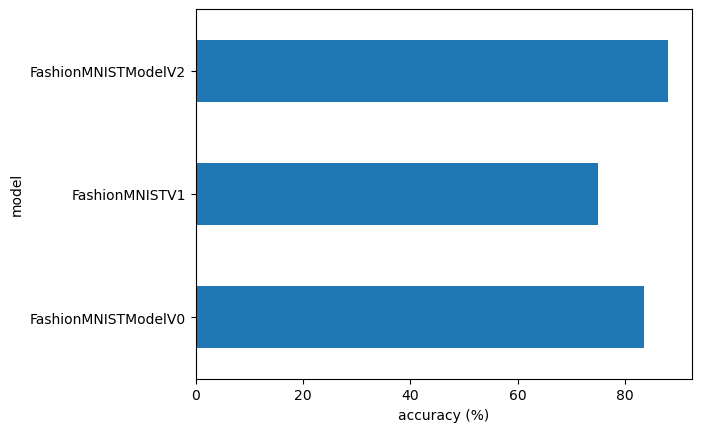

In [73]:
# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");

### Make and evaluate random predictions with best model¶

In [80]:
# create a function and pass model and some data to predict on it
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device=device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device)
            # forward pass
            pred_logit = model(sample)
            # get prediction probability
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            # get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [76]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# view the first test sample shape and label
test_samples[0].shape

torch.Size([1, 28, 28])

In [77]:
# make prediction
pred_probs = make_predictions(model=model_2,
                              data=test_samples)
pred_probs[:2]

tensor([[1.3152e-06, 9.2834e-07, 8.8130e-07, 8.6436e-06, 3.7978e-07, 9.9737e-01,
         1.1206e-05, 4.3297e-04, 6.5283e-04, 1.5223e-03],
        [3.2231e-02, 4.5375e-01, 3.3602e-03, 4.3849e-01, 2.8862e-02, 1.3026e-04,
         4.1602e-02, 9.5445e-04, 3.2385e-04, 2.9226e-04]])

In [78]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

In [79]:
test_labels, pred_classes

([5, 1, 7, 4, 3, 0, 4, 7, 1], tensor([5, 1, 7, 4, 3, 0, 4, 7, 1]))

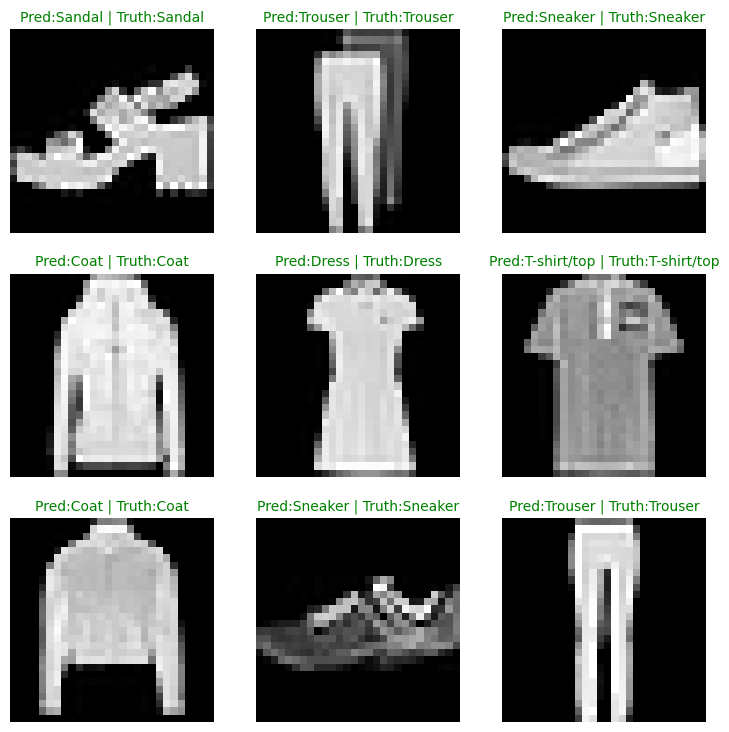

In [83]:
# visualize the results
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    # create a subplot
    plt.subplot(nrows, ncols, i + 1)
    # plot the target image
    plt.imshow(sample.squeeze(), cmap="gray")
    # find the prediction label 
    pred_label = class_names[pred_classes[i]]
    # get the true lable
    truth_label = class_names[test_labels[i]]
    # create the tile text
    title_text = f"Pred:{pred_label} | Truth:{truth_label}"
    # check for equality and change title colour accordingly
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")
    else:
        plt.title(title_text, fontsize=10, c="r")
    plt.axis(False);

### Making a confusion matrix for further prediction evaluation
* make prediction with model 2
* make a confusion matrix using torchmetrics.ConfusionMatrix
* plot the confusion matrix using mlxend.plotting.plot_confution_matrix()

In [84]:
# make predictions
y_preds = []
model_2.eval()
with torch.inference_mode():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        # do the forward pass
        y_logit = model_2(X)
        # turn predictions from logits -> prediction prob -> predictions labels
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        # put predictions on CPU for evaluation
        y_preds.append(y_pred.cpu())
# concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

In [85]:
# see if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
except:
    !pip install -q torchmetrics -U mlxtend
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.1


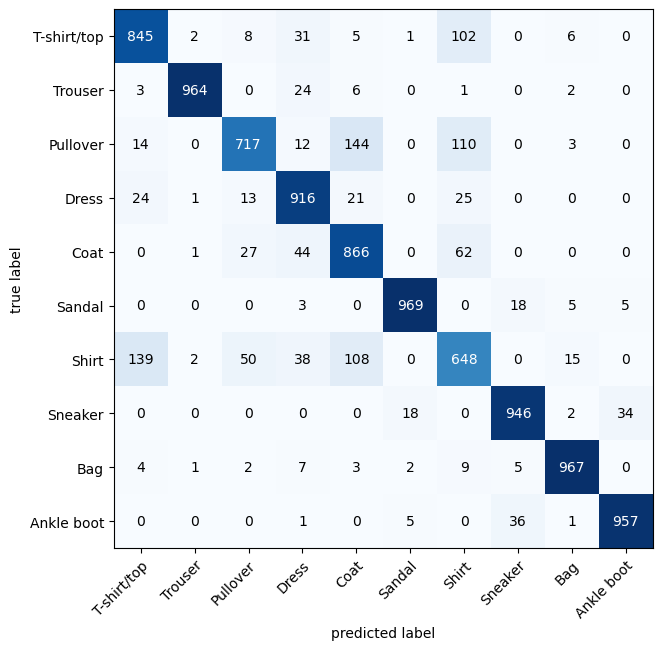

In [86]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

### Save and load best performing model
* torch.save - a function to save a whole PyTorch model or a model's state_dict().
* torch.load - a function to load in a saved PyTorch object.
* torch.nn.Module.load_state_dict() - a function to load a saved state_dict() into an existing model instance.

In [88]:
from pathlib import Path

# create models directory if it doesn't exist
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)
# create model save path
MODEL_NAME = "03_pytorch_computer_version_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# save the model state dict
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to : models/03_pytorch_computer_version_model_2.pth


In [89]:
# create a new instance of FashionMNISTModelV2
loaded_model_2 = FashionMNISTModelV2(input_shape=1,
                                     hidden_units=10,
                                     output_shape=10)
# load in the saved state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# send model to gpu or cpu
loaded_model_2 = loaded_model_2.to(device)

In [90]:
# evaluate the loaded model
torch.manual_seed(42)

loaded_model_2_results = eval_model(
    model=loaded_model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

loaded_model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.331485778093338,
 'model_acc': 87.94928115015975}

In [91]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.331485778093338,
 'model_acc': 87.94928115015975}

In [92]:
# Check to see if results are close to each other (if they are very far away, there may be an error)
torch.isclose(torch.tensor(model_2_results["model_loss"]), 
              torch.tensor(loaded_model_2_results["model_loss"]),
              atol=1e-08, # absolute tolerance
              rtol=0.0001) # relative tolerance

tensor(True)